# EXPLORE DATABASE

In [2]:
import psycopg2
import pandas as pd
import geopandas as gpd
import datetime as dt
from shapely import wkt
from shapely.geometry import box
import time
import matplotlib.pyplot as plt

In [3]:
(nlat, slat, wlon, elon) = (90, -90, -180, 180)
params = {
            'start_date': dt.datetime(2003, 1, 1),
            'end_date': dt.datetime(2003, 1, 9),
            'nlat': nlat,
            'slat': slat,
            'wlon': wlon,
            'elon': elon
        }

# 1. CHECK which of pandas or geopands is fastest for a query:
### result: pandas is slightly faster (especially for long queries)

In [3]:
start = time.time()
query_pandas = """SELECT datetime, ST_AsText(geom) AS geom FROM gfas_cfire_flux
            WHERE datetime > %(start_date)s AND datetime < %(end_date)s AND
            geom && ST_MakeEnvelope(%(wlon)s, %(slat)s, %(elon)s, %(nlat)s, 4326)
            ORDER BY datetime;"""
with psycopg2.connect("dbname='wfdb' user='wfuser' host='localhost'") as conn:
#     tabl = pd.read_sql_query("select * from gfas_cfire_flux ORDER BY datetime ASC LIMIT 10;",conn)
    tabl = pd.read_sql_query(query_pandas, conn,
                            params = params)
tabl['geom'] = tabl.geom.apply(wkt.loads)
tabl = gpd.GeoDataFrame(tabl[['datetime']], geometry = tabl['geom'])
print(f'PANDAS processed in {time.time()-start:.03f} s')

start = time.time()
query_geopandas = """SELECT datetime, geom FROM gfas_cfire_flux
            WHERE datetime > %(start_date)s AND datetime < %(end_date)s AND
            geom && ST_MakeEnvelope(%(wlon)s, %(slat)s, %(elon)s, %(nlat)s, 4326)
            ORDER BY datetime;"""
with psycopg2.connect("dbname='wfdb' user='wfuser' host='localhost'") as conn:
#     tabl = pd.read_sql_query("select * from gfas_cfire_flux ORDER BY datetime ASC LIMIT 10;",conn)
    tabl = gpd.read_postgis(query_geopandas, conn,
                            params = params)
print(f'GEOPANDAS processed in {time.time()-start:.03f} s')

PANDAS processed in 3.013 s
GEOPANDAS processed in 3.323 s


## CHECK SPATIAL EXTENT: group by geometry all data

In [8]:
start = time.time()
# query_pandas = """SELECT ST_ClusterDBSCAN(geom, 0.5, 1) OVER() AS clst_id,
#        ST_AsText(geom) AS geom, COUNT(value) FROM gfas_cfire_flux
#        GROUP BY geom;"""
query_pandas = """SELECT ST_AsText(geom) AS geom, COUNT(value) as counts, SUM(value) as sums FROM gfas_cfire_flux
       GROUP BY geom;"""

with psycopg2.connect("dbname='wfdb' user='wfuser' host='localhost'") as conn:
    tabl = pd.read_sql_query(query_pandas, conn)

# CREATE shapefile
tabl['geometry'] = tabl.geom.apply(wkt.loads)
tabl = gpd.GeoDataFrame(tabl[[f for f in tabl.columns if f!='geometry']], geometry = tabl['geometry'], crs = 'EPSG:4326')
print(f'PANDAS processed in {time.time()-start:.03f} s')

# AGGREGATE BY CLUSTER
# dis_tabl = tabl.dissolve('clst_id',aggfunc='sum')
# dis_tabl2 = dis_tabl.copy()
# dis_tabl2['geometry'] = dis_tabl.centroid

PANDAS processed in 76.746 s


In [9]:
start = time.time()
#cluster by 0.5 DEG
tabl['clust'] = [f'{xx}_{yy}' for xx,yy in zip(((tabl.geometry.x*2).round())/2,((tabl.geometry.y*2).round())/2)]

dis_tabl = tabl.groupby('clust').sum()
dis_tabl2 = dis_tabl.copy()
def get_boxes_from_index(poi, buf = 0.25):
    xx,yy = [float(f) for f in poi.split('_')]
    return box(xx-buf, yy-buf, xx+buf, yy+buf)
dis_tabl = tabl.groupby('clust').sum()
dis_tabl2 = dis_tabl.copy()
dis_tabl2['geometry'] = pd.Series(dis_tabl.index, index=dis_tabl.index).apply(get_boxes_from_index)
# dis_tabl2['geometry'] = dis_tabl.centroid
print(f'CLUSTERING PROCESSED in {time.time()-start:.03f} s')

CLUSTERING PROCESSED in 20.268 s


In [6]:
start = time.time()

query_geopandas = """SELECT geom, COUNT(value) FROM gfas_cfire_flux
GROUP BY geom;"""
with psycopg2.connect("dbname='wfdb' user='wfuser' host='localhost'") as conn:
    tabl = gpd.read_postgis(query_geopandas, conn)
# ax = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).sort_values('name').boundary.plot(color = 'r')
# tabl.plot(ax=ax, zorder = 100, alpha = 0.3)
print(f'GEOPANDAS processed in {time.time()-start:.03f} s')

GEOPANDAS processed in 79.618 s


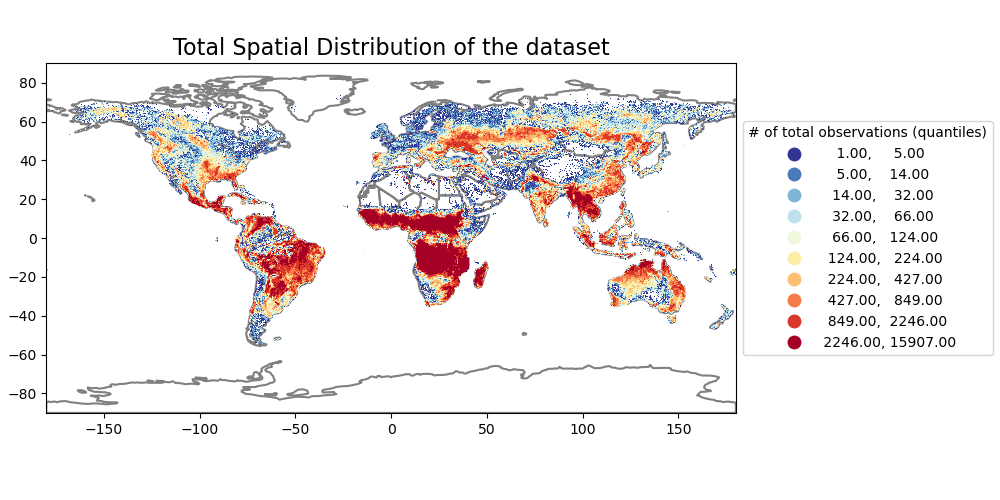

In [7]:
%matplotlib widget

# ss = tabl.groupby('clst_id').sum()
outfile = '/home/esowc32//PROJECT/DATA/DatabaseData/IMAGES/spatial_extension_190522.png'
fig, ax = plt.subplots(figsize = (10,5))
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).sort_values('name').boundary.plot(ax=ax, zorder = 0,
                                                                                                   color = 'grey', alpha = 1)
dis_tabl2.plot('counts', ax=ax, cmap='RdYlBu_r', legend=True,scheme='quantiles', k= 10,
               legend_kwds = dict(loc='center left', bbox_to_anchor=(1, 0.5), title = '# of total observations (quantiles)'))
fig.tight_layout()
ax.set_title('Total Spatial Distribution of the dataset', fontsize = 16)
fig.savefig(outfile, facecolor = 'w', dpi = 300)

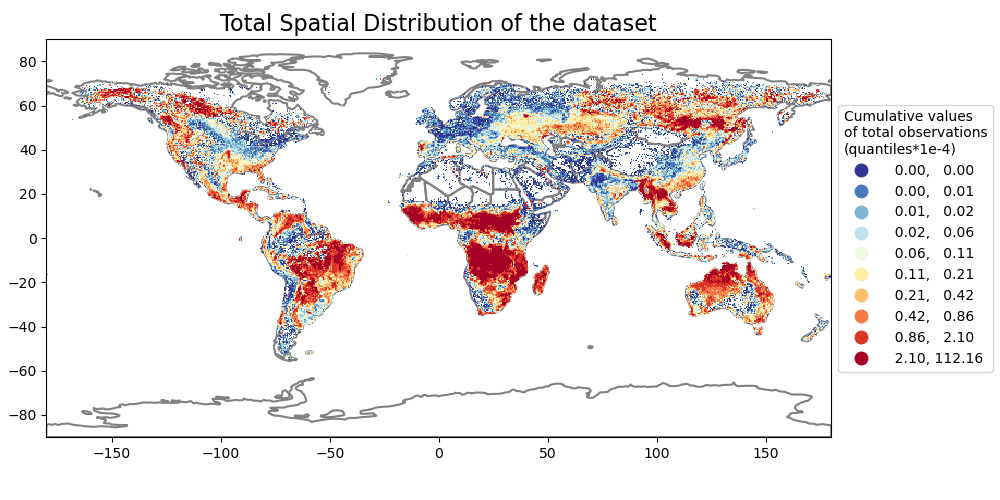

In [47]:
%matplotlib widget

# ss = tabl.groupby('clst_id').sum()
outfile = '/home/esowc32//PROJECT/DATA/DatabaseData/IMAGES/CUMULATIVE VALUES_spatial_190522.png'
fig, ax = plt.subplots(figsize = (10,5))
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).sort_values('name').boundary.plot(ax=ax, zorder = 0,
                                                                                                   color = 'grey', alpha = 1)
dis_tabl2.plot('sums*1e4', ax=ax, cmap='RdYlBu_r', legend=True, scheme='quantiles', k= 10,
               legend_kwds = dict(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Cumulative values \nof total observations\n(quantiles*1e-4)'))
fig.tight_layout()
ax.set_title('Total Spatial Distribution of the dataset', fontsize = 16)
fig.savefig(outfile, facecolor = 'w', dpi = 300)

In [8]:
# fig, ax = plt.subplots(figsize = (10,5))
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)
# dis_tabl2.plot('count',ax=ax, cmap='RdYlBu_r', legend=True,scheme='quantiles', k= 10,
#                legend_kwds = dict(loc='center left', bbox_to_anchor=(1, 0.5), title = '# of total observations (quantiles)'))
# fig.tight_layout()

# fig, ax = plt.subplots(figsize = (10,5))
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)
# dis_tabl2.plot('count',ax=ax, cmap='RdYlBu_r', legend=True,scheme='quantiles', k= 15,
#                legend_kwds = dict(loc='center left', bbox_to_anchor=(1, 0.5), title = '# of total observations (quantiles)'))
# fig.tight_layout()

# fig, ax = plt.subplots(figsize = (10,5))
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)
# dis_tabl2.plot('count',ax=ax,  cmap='RdYlBu_r', legend=True,scheme='quantiles', k= 25,
#                legend_kwds = dict(loc='center left', bbox_to_anchor=(1, 0.5), title = '# of total observations (quantiles)'))
# fig.tight_layout()

In [43]:
import mapclassify
mapclassify.Quantiles(dis_tabl2.sums*1e4, k=10)

Quantiles               

    Interval       Count
------------------------
[  0.00,   0.00] |  4753
(  0.00,   0.01] |  4753
(  0.01,   0.02] |  4753
(  0.02,   0.06] |  4752
(  0.06,   0.11] |  4753
(  0.11,   0.21] |  4753
(  0.21,   0.42] |  4752
(  0.42,   0.86] |  4753
(  0.86,   2.10] |  4753
(  2.10, 112.16] |  4753

In [9]:
import mapclassify
mapclassify.Quantiles(dis_tabl2['count'], k =10)

Quantiles                   

      Interval         Count
----------------------------
[    1.00,     5.00] |  5263
(    5.00,    14.00] |  4402
(   14.00,    32.00] |  4634
(   32.00,    66.00] |  4781
(   66.00,   124.00] |  4744
(  124.00,   224.00] |  4695
(  224.00,   427.00] |  4760
(  427.00,   849.00] |  4749
(  849.00,  2246.00] |  4748
( 2246.00, 15907.00] |  4752

# CHECK temporal extent

In [10]:
start = time.time()

query_pandas = """SELECT datetime, COUNT(value) FROM gfas_cfire_flux
GROUP BY datetime ORDER BY datetime;"""
with psycopg2.connect("dbname='wfdb' user='wfuser' host='localhost'") as conn:
    tabl2 = pd.read_sql_query(query_pandas, conn)

print(f'PANDAS processed in {time.time()-start:.03f} s')

PANDAS processed in 2.794 s


In [11]:
# CHECK that there is no empty day in the database
all_days = set(pd.date_range(tabl2.datetime.values[0],tabl2.datetime.values[-1]))
database_days = set(tabl2.datetime) 
assert len(all_days-database_days)==0 

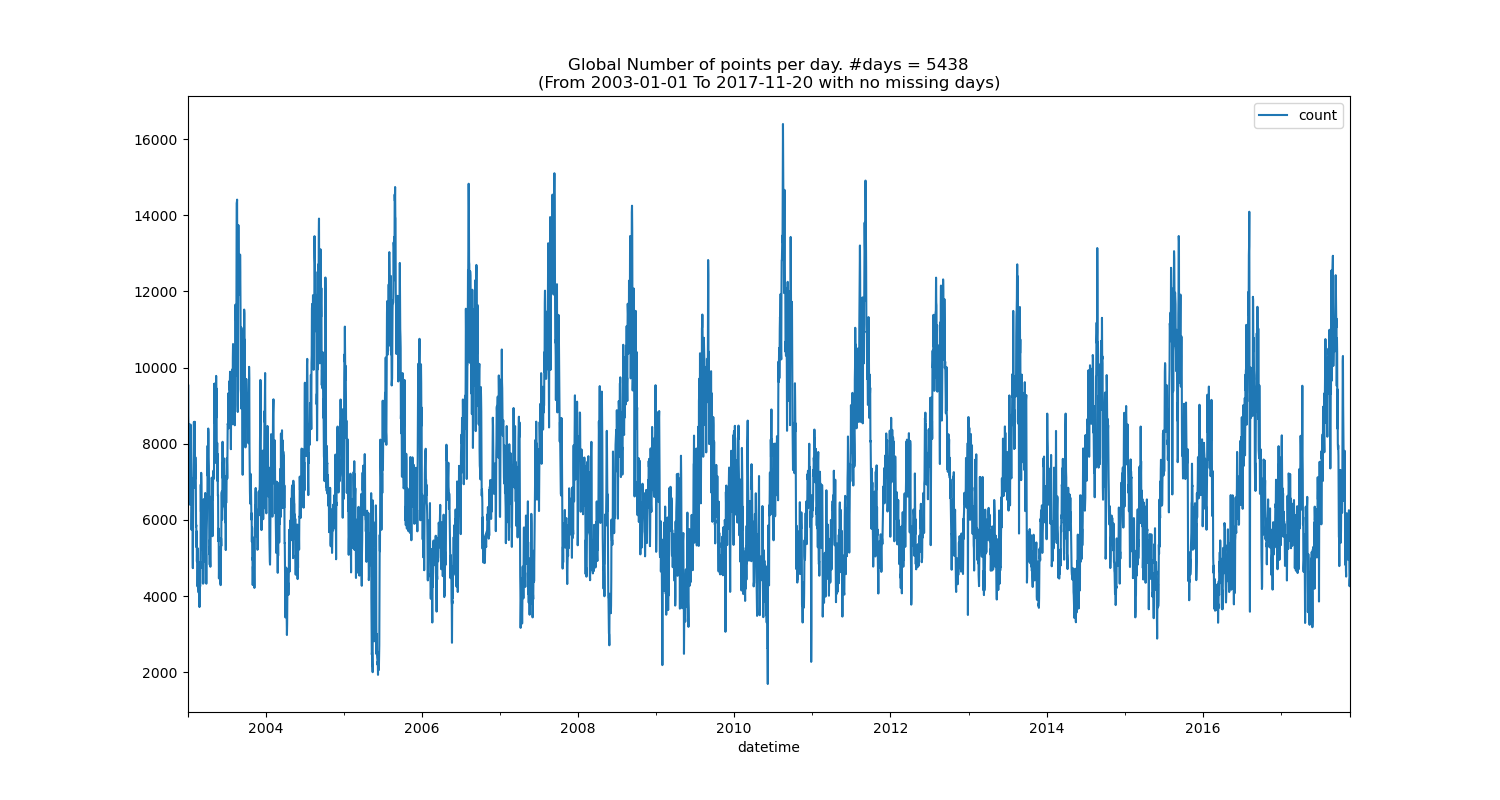

In [12]:
outfile = '/home/esowc32//PROJECT/DATA/DatabaseData/IMAGES/temporal_extension_190522.png'
fig, ax = plt.subplots(figsize = (15,8))
ax = tabl2.plot(x = 'datetime', y = 'count',ax=ax)
ax.set_title(f"Global Number of points per day. #days = {len(tabl2)}\n(From {str(tabl2.datetime.values[0]).split('T')[0]} To {str(tabl2.datetime.values[-1]).split('T')[0]} with no missing days)")
fig.savefig(outfile, facecolor = 'w')